In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# 기존 데이터
df_pitcher = pd.read_csv("투수_데이터_최종.csv")


df_pitcher['K/9'] = df_pitcher['탈삼진']/df_pitcher['이닝수']*9
df_pitcher['BB/9'] = df_pitcher['사사구']/df_pitcher['이닝수']*9



era_stats = df_pitcher.groupby('선수명').agg({
    '자책점': 'sum',
    '이닝수': 'sum'
}).reset_index()

# ERA* 계산
era_stats['ERA*'] = (era_stats['자책점'] / era_stats['이닝수']) * 9

# ERA*를 df_train에 병합
df_pitcher = pd.merge(df_pitcher, era_stats[['선수명', 'ERA*']], on='선수명', how='left')

In [2]:
#df_train.to_csv('투수_데이터_최종_', index = False)

In [3]:
df_train = df_pitcher[~((df_pitcher['구분'] == 'FA 1년차') & (df_pitcher['n차'] == 0))]

## 구원 투수로 필터링

In [4]:
# 1. df_train에서 선수별 평균 '구원 이닝' 계산
relief_pitcher_stats = df_train.groupby('선수명')['구원 이닝'].mean()

# 2. 평균 '구원 이닝'이 28보다 큰 선수들의 이름만 추출
relief_pitcher_names = relief_pitcher_stats[relief_pitcher_stats > 28].index

print(f"총 {len(relief_pitcher_names)}명의 구원 투수가 확인되었습니다.")
print(list(relief_pitcher_names))


# 3. 이전에 집계된 최종 df_train에서 해당 선수들만 필터링
df_relief = df_train[df_train['선수명'].isin(relief_pitcher_names)].copy()

print("\n--- 구원 투수만 필터링된 최종 데이터 ---")
print(df_relief.head())

총 40명의 구원 투수가 확인되었습니다.
['강영식(1차)', '고효준(1차)', '권오준(1차)', '권혁(1차)', '김대우(1차)', '김사율(1차)', '김상수(1차)', '김상수(2차)', '김승회(1차)', '김재윤(1차)', '김진성(1차)', '마일영(1차)', '마정길(1차)', '박정진(1차)', '봉중근(1차)', '손승락(1차)', '송은범(2차)', '심수창(1차)', '안지만(1차)', '오승환(2차)', '오주원(1차)', '우규민(2차)', '원종현(1차)', '유동훈(1차)', '윤길현(1차)', '이동현(1차)', '이보근(1차)', '이재영(1차)', '이정훈(1차)', '이태양(1차)', '이현승(1차)', '임창민(1차)', '정우람(1차)', '정우람(2차)', '정현욱(1차)', '주권(1차)', '진해수(1차)', '차우찬(1차)', '채병용(1차)', '홍건희(1차)']

--- 구원 투수만 필터링된 최종 데이터 ---
   FA년도  구단명      선수명 세부 포지션   투    구분 FA등급  플레이년도  나이  게임수  ...  국대출전횟수  구종1  \
0  2011   롯데  강영식(1차)     RP  좌투  자격유지    A   2010  29   63  ...       0  NaN   
1  2012   롯데  강영식(1차)     RP  좌투  자격유지    A   2011  30   64  ...       0  NaN   
2  2013   롯데  강영식(1차)     RP  좌투  자격유지    A   2012  31   55  ...       0  NaN   
3  2014   롯데  강영식(1차)     RP  좌투  자격유지    A   2013  32   55  ...       0   포심   
5  2017  KIA  고효준(1차)     RP  좌투    신규    A   2016  33   24  ...       0   포심   

   구종2  구종1 구종가치  WHIP 

In [5]:
# 극단치가 많아 분류에 혼선을 주는'차우찬(1차)' ,'권오준(1차)', '윤길현(1차)' 로우를 분석에서  제외
df_relief = df_relief[df_relief['선수명'] != '권오준(1차)']
df_relief = df_relief[df_relief['선수명'] != '차우찬(1차)']
df_relief = df_relief[df_relief['선수명'] != '윤길현(1차)']
# 1. FA 계약 정보 처리 (0이 아닌 값이 있으면 그걸로 대체)
def fill_fa_info(x):
    years = x['FA 계약 연수']
    total = x['FA 계약 총액']
    
    fa_years = years[years != 0]
    fa_total = total[total != 0]

    return pd.Series({
        'FA 계약 연수': fa_years.iloc[0] if not fa_years.empty else 0,
        'FA 계약 총액': fa_total.iloc[0] if not fa_total.empty else 0
    })

fa_info = df_relief.groupby('선수명').apply(fill_fa_info).reset_index()

# 2. 성과 지표 평균 처리
performance_cols = ['종합 WAR', 'ERA*', '이닝수', '투구수','선발 이닝','구원 이닝','나이']  # 평균 낼 컬럼들로 수정

performance_avg = df_relief.groupby('선수명')[performance_cols].mean().reset_index()

# 3. 평균 내지 않는 컬럼(문자열 등) 처리 → 첫 값 가져오기
extra_cols = ['K/9', 'BB/9', 'FIP','피장타율' ]  # 추가하고 싶은 컬럼
extra_info = df_relief.groupby('선수명')[extra_cols].last().reset_index()

# 4. 병합
df = (
    performance_avg
    .merge(fa_info, on='선수명', how='left')
    .merge(extra_info, on='선수명', how='left')
)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_5820\2139709182.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fa_info = df_relief.groupby('선수명').apply(fill_fa_info).reset_index()


In [6]:
df.isna().sum()

선수명         0
종합 WAR      0
ERA*        0
이닝수         0
투구수         0
선발 이닝       0
구원 이닝       0
나이          0
FA 계약 연수    0
FA 계약 총액    0
K/9         0
BB/9        0
FIP         0
피장타율        0
dtype: int64

## 적절한 클러스터 수 찾기

C:\Users\woowo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\woowo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\woowo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\woowo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

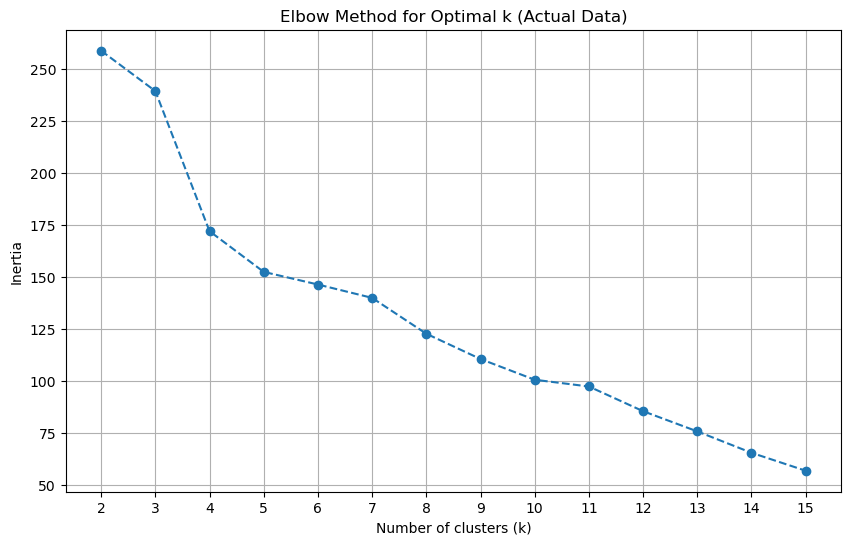

In [7]:

# 스케일링 + 클러스터링
features = ['종합 WAR','ERA*', '이닝수', '투구수',
       'K/9', 'BB/9', 'FIP','나이','피장타율']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

inertia = []
K_range = range(2, 16) # k를 2부터 15까지 테스트

for k in K_range:
    # n_init='auto'로 설정하여 경고 메시지가 뜨지 않도록 합니다.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# 4. 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (Actual Data)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show()



## 적절한 PCA 수 찾기

--- [구원 투수] 주성분별 설명 분산 및 누적 분산 ---
     Explained Variance  Cumulative Variance
PC1            0.320823             0.320823
PC2            0.290462             0.611285
PC3            0.126890             0.738175
PC4            0.109243             0.847419
PC5            0.077081             0.924500
PC6            0.046659             0.971159
PC7            0.014579             0.985737
PC8            0.012042             0.997780
PC9            0.002220             1.000000


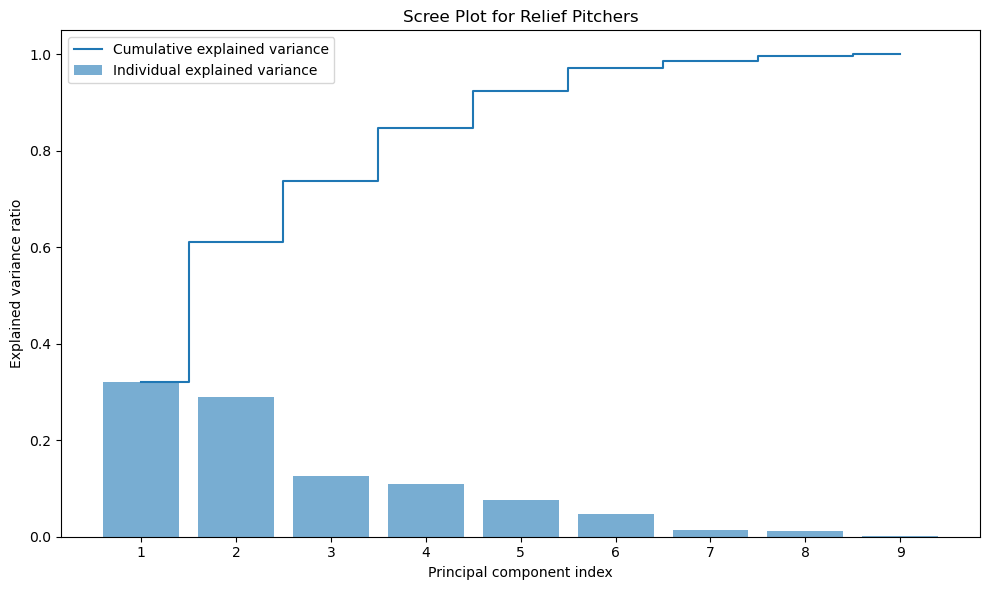

In [50]:


# 1. 분석할 피처 선택 및 스케일링
features = ['종합 WAR','ERA*', '이닝수', '투구수', 'K/9', 'BB/9','FIP','나이','피장타율']
X_relief = df[features]
scaler_relief = StandardScaler()
X_relief_scaled = scaler_relief.fit_transform(X_relief)

# 2. PCA 실행 (모든 주성분 계산)
pca_relief = PCA()
pca_relief.fit(X_relief_scaled)

# 3. 누적 설명 분산 계산
explained_variance_relief = pca_relief.explained_variance_ratio_
cumulative_variance_relief = np.cumsum(explained_variance_relief)

print("--- [구원 투수] 주성분별 설명 분산 및 누적 분산 ---")
pc_df = pd.DataFrame({
    'Explained Variance': explained_variance_relief,
    'Cumulative Variance': cumulative_variance_relief
}, index=[f'PC{i+1}' for i in range(len(explained_variance_relief))])
print(pc_df)


# 4. 스크리 그림(Scree Plot) 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_relief) + 1), explained_variance_relief, alpha=0.6, label='Individual explained variance')
plt.step(range(1, len(explained_variance_relief) + 1), cumulative_variance_relief, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Scree Plot for Relief Pitchers')
plt.xticks(range(1, len(explained_variance_relief) + 1))
plt.legend(loc='best')
plt.tight_layout()
plt.show()

원본 9개 피처가 4개의 주성분으로 변환되었습니다.
각 주성분의 설명 분산(정보량): [0.32082322 0.29046197 0.12689002 0.10924345]
총 설명 분산: 0.85


C:\Users\woowo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


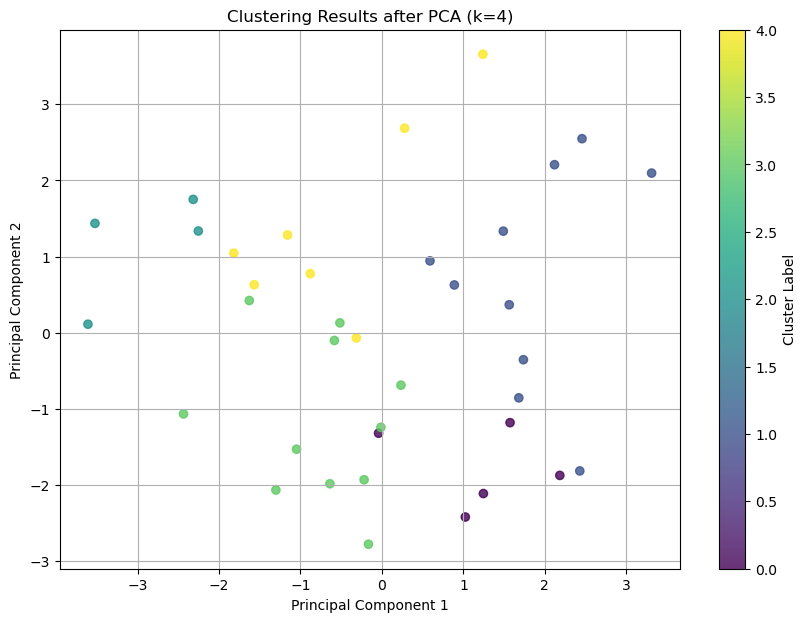

In [36]:

from sklearn.decomposition import PCA




# 1. PCA 변환
# 주성분 개수를 4개로 설정(>87%)
n_components = 4
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print(f"원본 {X_scaled.shape[1]}개 피처가 {pca.n_components_}개의 주성분으로 변환되었습니다.")
print(f"각 주성분의 설명 분산(정보량): {pca.explained_variance_ratio_}")
print(f"총 설명 분산: {sum(pca.explained_variance_ratio_):.2f}")


# 2. PCA 데이터로 K-평균 군집분석 실행
# k=5로 설정하여 군집화
n_clusters = 5
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')

# 결과를 데이터프레임에 새로운 컬럼으로 추가
df['pca_cluster'] = kmeans_pca.fit_predict(X_pca)


# 3. 결과 시각화
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['pca_cluster'], cmap='viridis', alpha=0.8)

# 각 점에 선수 이름 표시 (선택 사항 - 데이터가 많으면 지저분해 보일 수 있음)
# for i, name in enumerate(df_filtered['선수명']):
#     plt.text(X_pca[i, 0], X_pca[i, 1], name, fontsize=9)

plt.title('Clustering Results after PCA (k=4)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()


## 클러스터링

--- 주성분 적재(PCA Loadings) ---
             PC1       PC2       PC3       PC4
종합 WAR -0.433400  0.250180  0.360165  0.243308
ERA*    0.477918  0.008465 -0.427216 -0.208503
이닝수    -0.008415  0.593835  0.032047  0.132009
투구수     0.088011  0.568212 -0.050166  0.185468
K/9    -0.261802 -0.217004 -0.445478  0.388250
BB/9    0.168797 -0.355826  0.095038  0.690410
피장타율    0.477435 -0.002267  0.342457  0.342598
FIP     0.086109 -0.242394  0.598534 -0.307922
나이      0.493509  0.171376  0.034944  0.076871


C:\Users\woowo\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\woowo\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\woowo\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\woowo\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 45789 (\N{HANGUL SYLLABLE NING}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\woowo\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\woowo\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from font(s) DejaVu Sans.
  fig.ca

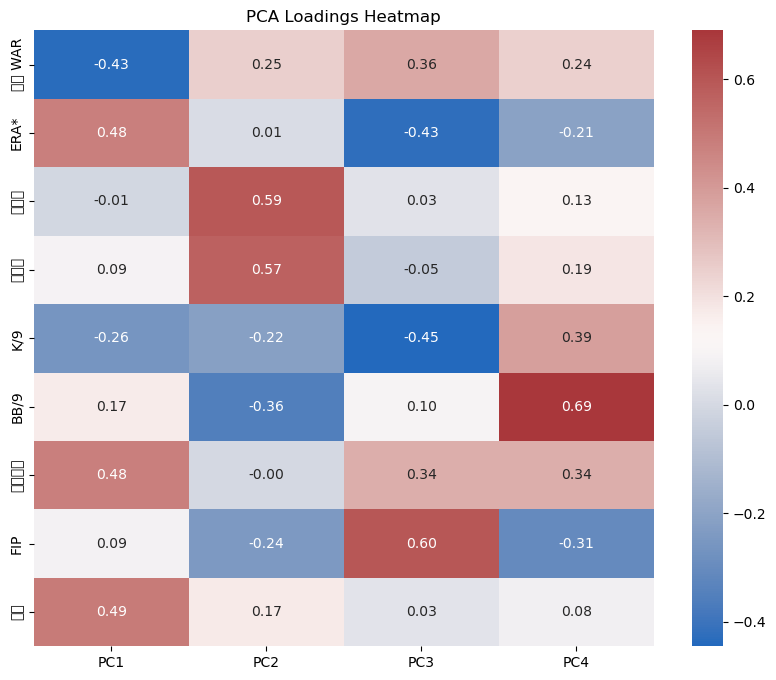

In [10]:
# 1. 주성분 적재(PCA Loadings)를 데이터프레임으로 변환
# pca.components_ 속성에 각 주성분의 적재값이 들어있습니다.
loadings_df = pd.DataFrame(
    data=pca.components_.T,  # T를 붙여 행과 열을 바꿉니다.
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=features
)

print("--- 주성분 적재(PCA Loadings) ---")
print(loadings_df)


# 2. 히트맵(Heatmap)으로 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, fmt='.2f', cmap='vlag')
plt.title('PCA Loadings Heatmap')
plt.show()


In [11]:
#kmeans = KMeans(n_clusters=4, random_state=42)
#df['cluster_label'] = kmeans.fit_predict(X_scaled)

In [12]:
df['pca_cluster'].unique()

array([3, 0, 1, 4, 2])

### 클러스터 0

In [13]:
# '클러스터 0'에 속한 선수들만 필터링
cluster_0_players = df[df['pca_cluster'] == 0]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_0_players[['선수명'] + features])

# 만약 선수 이름만 보고 싶다면
# print(cluster_0_players['player_name'])

        선수명  종합 WAR      ERA*    이닝수         투구수        K/9      BB/9   피장타율  \
1   고효준(1차)  0.2525  5.435005  45.05  862.750000  10.434783  5.652174  0.397   
11  마정길(1차)  0.7800  4.515966  44.70  816.333333   8.005391  5.579515  0.401   
12  박정진(1차)  1.1825  3.899745  58.85  958.500000   8.915094  6.367925  0.338   
13  봉중근(1차)  1.3500  3.316274  48.85  856.500000   4.986150  5.983380  0.425   
25  이재영(1차)  0.3950  4.828862  46.30  789.500000   7.875000  5.250000  0.441   

     FIP    나이  
1   3.81  34.5  
11  5.07  35.0  
12  4.62  35.5  
13  6.22  34.5  
25  5.61  33.5  


### 클러스터 1

In [14]:
# '클러스터 1'에 속한 선수들만 필터링
cluster_1_players = df[df['pca_cluster'] == 1]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_1_players[['선수명'] + features])

# 만약 선수 이름만 보고 싶다면
# print(cluster_0_players['player_name'])

        선수명    종합 WAR      ERA*        이닝수          투구수       K/9      BB/9  \
3   김대우(1차)  0.485000  5.234375  49.075000   831.750000  6.890625  3.515625   
4   김사율(1차)  1.367500  4.537293  66.100000  1115.500000  8.078382  3.754741   
7   김승회(1차)  0.995000  4.721524  56.025000   946.000000  5.347826  3.000000   
10  마일영(1차) -0.190000  6.396747  67.675000  1207.250000  4.558824  2.941176   
15  송은범(2차)  0.806000  5.522672  73.660000  1298.400000  5.400000  3.900000   
16  심수창(1차) -0.206667  6.486156  44.166667   796.666667  9.357045  3.939808   
24  이보근(1차)  0.873333  5.160124  59.133333  1098.000000  7.967213  2.655738   
28  이현승(1차)  0.476667  4.277567  52.800000   892.000000  6.451049  3.776224   
33   주권(1차)  1.445000  4.168490  54.050000   836.250000  3.255319  4.021277   
35  채병용(1차)  0.917500  5.421400  73.825000  1318.000000  8.457831  3.253012   

     피장타율   FIP         나이  
3   0.450  4.40  33.500000  
4   0.494  5.22  32.500000  
7   0.460  4.70  34.500000  
10  0.486  4.3

### 클러스터 2

In [15]:
# '클러스터 2'에 속한 선수들만 필터링
cluster_2_players = df[df['pca_cluster'] == 2]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_2_players[['선수명'] + features])

# 만약 선수 이름만 보고 싶다면
# print(cluster_2_players['player_name'])

        선수명  종합 WAR      ERA*     이닝수      투구수        K/9      BB/9   피장타율  \
8   김재윤(1차)  2.4650  3.134052  64.625  1028.50   8.282209  1.932515  0.290   
30  정우람(1차)  1.9650  2.798319  59.500   972.00  11.571429  3.728571  0.291   
31  정우람(2차)  2.3250  2.795699  62.775  1056.25   7.435456  2.633391  0.353   
32  정현욱(1차)  2.1325  3.157895  70.850  1109.00   6.945338  3.038585  0.332   

     FIP    나이  
8   2.40  31.5  
30  2.58  28.5  
31  3.42  32.5  
32  2.75  32.5  


### 클러스터 3

In [16]:
# '클러스터 3'에 속한 선수들만 필터링
cluster_3_players = df[df['pca_cluster'] == 3]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_3_players[['선수명'] + features])

# 만약 선수 이름만 보고 싶다면
# print(cluster_3_players['player_name'])

        선수명  종합 WAR      ERA*     이닝수     투구수        K/9      BB/9   피장타율  \
0   강영식(1차)  0.8750  4.161378  43.400  767.50   9.183673  4.821429  0.298   
2    권혁(1차)  0.9775  3.896243  41.875  699.25  10.000000  2.894737  0.368   
6   김상수(2차)  0.7175  4.574468  42.300  757.75   6.230769  4.153846  0.302   
9   김진성(1차)  0.5150  3.573113  46.075  760.25   8.379310  3.568966  0.337   
18  오승환(2차)  1.8425  2.876532  57.100  949.50   6.366559  2.459807  0.404   
19  오주원(1차)  1.3875  4.527163  57.600  891.50   6.820702  1.663586  0.309   
21  원종현(1차)  0.6150  3.975328  58.275  922.25   7.131537  2.567353  0.331   
22  유동훈(1차)  1.6700  2.790979  49.050  719.25   7.676471  3.176471  0.349   
26  이정훈(1차)  0.9275  4.037855  54.075  875.00   6.530612  4.489796  0.399   
29  임창민(1차)  0.3225  3.869077  37.650  682.25   7.792208  3.701299  0.357   
34  진해수(1차)  0.4275  4.697597  47.850  841.25   8.142857  3.857143  0.360   

     FIP    나이  
0   3.22  30.5  
2   3.87  29.5  
6   3.78  33.5  
9   3.7

### 클러스터 4

In [17]:
# '클러스터 4'에 속한 선수들만 필터링
cluster_4_players = df[df['pca_cluster'] == 4]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_4_players[['선수명'] + features])


        선수명  종합 WAR      ERA*     이닝수      투구수       K/9      BB/9   피장타율  \
5   김상수(1차)  1.0875  4.376997  55.900   996.00  8.454012  4.227006  0.372   
14  손승락(1차)  1.6525  3.210191  58.875   949.25  9.279869  2.356792  0.405   
17  안지만(1차)  2.1050  2.961702  68.600  1118.00  9.710145  4.927536  0.344   
20  우규민(2차)  1.4275  4.708249  74.550  1208.50  5.625000  1.875000  0.416   
23  이동현(1차)  1.3450  3.606218  61.600  1020.50  8.375635  3.350254  0.398   
27  이태양(1차)  0.8275  4.608000  84.350  1344.50  4.901786  2.330357  0.411   
36  홍건희(1차)  1.1525  3.438078  66.375  1145.75  9.117647  3.529412  0.386   

     FIP    나이  
5   3.74  30.5  
14  3.40  31.5  
17  4.11  29.5  
20  3.76  33.5  
23  3.52  30.5  
27  4.76  30.5  
36  3.21  29.5  


### 클러스터별 피쳐들의 평균값

In [18]:
# 클러스터별 각 feature의 평균값 확인
cluster_means = df.groupby('pca_cluster')[features].mean()
print(cluster_means)

               종합 WAR      ERA*        이닝수          투구수       K/9      BB/9  \
pca_cluster                                                                   
0            0.792000  4.399170  48.750000   856.716667  8.043283  5.766599   
1            0.696933  5.192635  59.651000  1033.981667  6.576411  3.475760   
2            2.221875  2.971491  64.437500  1041.437500  8.558608  2.833266   
3            0.934318  3.907249  48.659091   805.977273  7.659518  3.395857   
4            1.371071  3.844205  67.178571  1111.785714  7.923442  3.228051   

                 피장타율       FIP         나이  
pca_cluster                                 
0            0.400400  5.066000  34.600000  
1            0.456200  4.759000  31.666667  
2            0.316500  2.787500  31.250000  
3            0.346727  3.528182  33.590909  
4            0.390286  3.785714  30.785714  


# 클러스터 별 선수들의 1년차 성적 변화 확인

In [19]:
# '구분' 컬럼이 'FA 1년차'인 로우들만 필터링합니다.
df_1 = df_pitcher[df_pitcher['구분'] == 'FA 1년차'].copy()

# 1. df_pitcher에서 선수별 평균 '구원 이닝' 계산
relief_pitcher_stats = df_1.groupby('선수명')['구원 이닝'].mean()

# 2. 평균 '구원 이닝'이 28보다 큰 선수들의 이름만 추출
relief_pitcher_names = relief_pitcher_stats[relief_pitcher_stats > 28].index

print(f"조건에 맞는 총 {len(relief_pitcher_names)}명의 구원 투수를 찾았습니다.")


# 3. 이전에 집계된 최종 df에서 해당 선수들만 필터링
df_1 = df_1[df_1['선수명'].isin(relief_pitcher_names)].copy()

print("\n--- 구원 투수만 필터링된 최종 분석 데이터 ---")
print(df_1['선수명'])


조건에 맞는 총 35명의 구원 투수를 찾았습니다.

--- 구원 투수만 필터링된 최종 분석 데이터 ---
4      강영식(1차)
14     권오준(1차)
19      권혁(1차)
33     김대우(1차)
43     김상수(1차)
48     김승회(1차)
53     김재윤(1차)
58     김진성(1차)
72     마정길(1차)
109    송은범(3차)
113    심수창(1차)
118    안영명(1차)
123    안지만(1차)
137    오승환(3차)
151    우규민(3차)
161    유동훈(1차)
176    윤길현(1차)
181    윤석민(1차)
195    이동현(1차)
204    이용찬(1차)
209    이재영(1차)
219    이정훈(1차)
224    이태양(1차)
228    이현승(1차)
238    임창민(1차)
243    장민재(1차)
248    장시환(1차)
259    정우람(2차)
263    정우람(3차)
273    정현욱(1차)
278     주권(1차)
283    진해수(1차)
297    채병용(1차)
312    홍건희(1차)
332    김상수(3차)
Name: 선수명, dtype: object


In [20]:
import re

# 1. 차수를 변경하는 함수 (이전과 동일)
def decrement_chasu_specific(name):
    # 이름에 '(숫자)차' 패턴이 있는지 확인
    match = re.search(r'\((\d+)차\)', str(name)) # str()을 추가하여 안전성 확보
    
    if match:
        num = int(match.group(1))
        # 차수가 1보다 클 경우 (2차, 3차 등)에만 변경
        if num > 1:
            new_num = num - 1
            new_suffix = f'({new_num}차)'
            return name.replace(match.group(0), new_suffix)
            
    # 그 외 모든 경우 (1차, 차수 없는 이름)는 원래 이름을 그대로 반환
    return name

# 2. df_1['선수명'] 컬럼에 위 함수를 적용하여 값 변경
df_1['선수명'] = df_1['선수명'].apply(decrement_chasu_specific)


In [21]:
df_1

,FA년도,구단명,선수명,세부 포지션,투,구분,FA등급,플레이년도,나이,게임수,...,국대출전횟수,구종1,구종2,구종1 구종가치,WHIP,AAV,n차,K/9,BB/9,ERA*
4,2015,롯데,강영식(1차),RP,좌투,FA 1년차,A,2014,33,52,...,0,포심,슬라,-5.6,1.49,42500.000000,0,8.042553,4.978723,4.161378
14,2019,삼성,권오준(1차),RP,우사,FA 1년차,A,2018,38,47,...,0,포심,첸접,0.7,1.27,30000.000000,0,10.858469,3.132251,5.063146
19,2016,한화,권혁(1차),CP,좌투,FA 1년차,A,2015,32,78,...,1,포심,슬라,16.2,1.58,80000.000000,0,7.071429,4.660714,3.896243
33,2025,삼성,김대우(1차),RP,우언,FA 1년차,C,2024,36,32,...,0,슬라,포심,-3.9,1.49,20000.000000,0,6.070381,3.167155,5.234375
43,2022,SSG,김상수(1차),CP,우투,FA 1년차,A,2021,33,50,...,4,포심,포크,-7.0,1.73,51666.666667,0,6.815835,4.802065,4.376997
48,2019,두산,김승회(1차),RP,우투,FA 1년차,A,2018,37,55,...,0,포심,슬라,3.9,1.41,15000.000000,0,5.645756,4.649446,4.721524
53,2025,삼성,김재윤(1차),RP,우투,FA 1년차,B,2024,34,65,...,0,포심,슬라,1.3,1.26,145000.000000,0,6.954545,3.545455,3.134052
58,2024,LG,김진성(1차),RP,우투,FA 1년차,C,2023,38,80,...,0,포심,포크,11.5,0.95,35000.000000,0,8.858773,3.338088,3.573113
72,2017,키움,마정길(1차),RP,우언,FA 1년차,A,2016,37,61,...,0,포심,슬라,10.6,1.49,31000.000000,0,7.405063,5.411392,4.515966
109,2021,LG,송은범(2차),RP,우투,FA 1년차,A,2020,36,56,...,1,슬라,투심,5.2,1.52,NaN,0,4.500000,3.535714,4.500000


In [37]:
fa_performance_columns = ['종합 WAR', 'ERA*', '이닝수', '투구수', 'K/9', 'BB/9', '피장타율','FIP','나이']
result_df = pd.DataFrame()

# 3. 각 군집(0~4)에 대해 반복 작업 수행
# df_relief['pca_cluster'].unique()를 통해 실제 존재하는 군집 번호만 가져옵니다.
for cluster_num in sorted(df['pca_cluster'].unique()):
    
    # 3-1. 현재 군집에 속한 선수들의 이름만 가져오기
    players_in_cluster = df[df['pca_cluster'] == cluster_num]['선수명']
    
    # 3-2. 'FA 1년차' 데이터에서 해당 선수들의 기록만 필터링
    fa_stats_of_cluster = df_1[df_1['선수명'].isin(players_in_cluster)]
    
    # 3-3. 필터링된 선수들의 평균 성적 계산
    mean_stats = fa_stats_of_cluster[fa_performance_columns].mean()
    
    # 3-4. 계산된 평균 성적을 결과 데이터프레임에 추가
    result_df[f'Cluster {cluster_num}'] = mean_stats

### 클러스터 별 FA 1년차 성적 평균

In [38]:
print(result_df.T)

             종합 WAR      ERA*        이닝수          투구수       K/9      BB/9  \
Cluster 0  0.955000  4.672414  47.100000   818.500000  7.476725  5.028277   
Cluster 1  0.772857  4.972787  64.371429  1071.857143  5.842678  3.625928   
Cluster 2  1.397500  3.478011  62.075000  1056.000000  7.781753  3.666128   
Cluster 3  1.241111  4.012851  64.722222  1120.444444  7.446174  4.120255   
Cluster 4  1.265000  3.716186  64.583333  1079.000000  7.594750  3.590606   

               피장타율       FIP         나이  
Cluster 0  0.480000  5.525000  36.500000  
Cluster 1  0.481143  5.011429  34.428571  
Cluster 2  0.397500  4.337500  33.750000  
Cluster 3  0.395444  4.421111  36.222222  
Cluster 4  0.422833  4.295000  33.166667  


In [39]:
df_new_players = pd.read_csv('2026_FA예정_투수.csv')

In [40]:
df_new = df_new_players.copy()

In [41]:


df_new['K/9'] = df_new['탈삼진']/df_new['이닝수']*9
df_new['BB/9'] = df_new['사사구']/df_new['이닝수']*9



era_stats = df_new.groupby('선수명').agg({
    '자책점': 'sum',
    '이닝수': 'sum'
}).reset_index()

# ERA* 계산
era_stats['ERA*'] = (era_stats['자책점'] / era_stats['이닝수']) * 9

# ERA*를 df_train에 병합
df_new = pd.merge(df_new, era_stats[['선수명', 'ERA*']], on='선수명', how='left')

df_new = df_new[df_new['선수명'] != '양현종']
df_new = df_new[df_new['선수명'] != '최원준']

In [42]:
# 2. 성과 지표 평균 처리
performance_cols_new = ['종합 WAR', 'ERA*', '이닝수', '투구수','선발 이닝','구원 이닝','나이']  # 평균 낼 컬럼들로 수정

performance_avg_new = df_new.groupby('선수명')[performance_cols_new].mean().reset_index()

# 3. 평균 내지 않는 컬럼(문자열 등) 처리 →마지막 값 가져오기
extra_cols_new = ['K/9', 'BB/9', 'FIP','피장타율' ]  # 추가하고 싶은 컬럼
extra_info_new = df_new.groupby('선수명')[extra_cols].last().reset_index()

# 4. 병합
df_new = (
    performance_avg_new
    .merge(extra_info_new, on='선수명', how='left')
)

In [43]:
df_new

,선수명,종합 WAR,ERA*,이닝수,투구수,선발 이닝,구원 이닝,나이,K/9,BB/9,FIP,피장타율
0,김범수,0.4700,4.073881,48.050,850.50,0.000,48.050,28.5,9.568106,4.784053,2.90,0.241
1,김상수,0.5475,4.596200,42.100,720.25,0.000,42.100,35.5,6.903409,5.369318,4.99,0.463
2,김태훈,0.5325,4.868421,51.300,712.00,0.000,51.300,31.5,9.957447,4.595745,3.91,0.418
3,서진용,0.9875,3.873539,47.050,808.50,0.000,47.050,31.5,0.000000,24.545455,11.05,0.250
4,심창민,0.0575,6.380597,20.100,416.75,0.000,20.100,28.5,14.516129,17.419355,5.68,0.167
5,이승현,0.5850,4.473823,47.275,851.25,0.000,47.275,32.5,6.157895,3.315789,5.65,0.513
6,이영하,0.4050,4.524941,63.150,1160.50,25.275,37.875,26.5,10.577689,5.916335,3.72,0.340
7,이준영,0.5700,3.730909,34.375,609.50,0.000,34.375,31.5,8.922414,3.103448,4.88,0.558
8,장필준,-0.3175,7.446043,20.850,408.50,2.550,18.125,34.5,0.000000,0.000000,4.20,1.000
9,조상우,0.5525,3.394343,45.075,803.25,0.000,45.075,28.5,9.418605,6.069767,4.35,0.423


In [44]:
new_X = df_new[features]

# 1. 기존 스케일러로 변환
new_X_scaled = scaler_relief.transform(new_X)

# 2. 기존 PCA로 변환
new_X_pca = pca.transform(new_X_scaled)

# 3. 기존 KMeans로 예측
new_clusters = kmeans_pca.predict(new_X_pca)

# 4. 결과를 새로운 데이터프레임에 추가
df_new['pca_cluster_new'] = new_clusters

# 결과 확인
print(df_new.head())

   선수명  종합 WAR      ERA*    이닝수     투구수  선발 이닝  구원 이닝    나이        K/9  \
0  김범수  0.4700  4.073881  48.05  850.50    0.0  48.05  28.5   9.568106   
1  김상수  0.5475  4.596200  42.10  720.25    0.0  42.10  35.5   6.903409   
2  김태훈  0.5325  4.868421  51.30  712.00    0.0  51.30  31.5   9.957447   
3  서진용  0.9875  3.873539  47.05  808.50    0.0  47.05  31.5   0.000000   
4  심창민  0.0575  6.380597  20.10  416.75    0.0  20.10  28.5  14.516129   

        BB/9    FIP   피장타율  pca_cluster_new  
0   4.784053   2.90  0.241                3  
1   5.369318   4.99  0.463                0  
2   4.595745   3.91  0.418                0  
3  24.545455  11.05  0.250                0  
4  17.419355   5.68  0.167                0  


In [45]:
# '클러스터 0'에 속한 선수들만 필터링
cluster_0_players_new = df_new[df_new['pca_cluster_new'] == 0]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_0_players_new[['선수명'] + features])

    선수명  종합 WAR      ERA*     이닝수     투구수        K/9       BB/9   피장타율    FIP  \
1   김상수  0.5475  4.596200  42.100  720.25   6.903409   5.369318  0.463   4.99   
2   김태훈  0.5325  4.868421  51.300  712.00   9.957447   4.595745  0.418   3.91   
3   서진용  0.9875  3.873539  47.050  808.50   0.000000  24.545455  0.250  11.05   
4   심창민  0.0575  6.380597  20.100  416.75  14.516129  17.419355  0.167   5.68   
5   이승현  0.5850  4.473823  47.275  851.25   6.157895   3.315789  0.513   5.65   
7   이준영  0.5700  3.730909  34.375  609.50   8.922414   3.103448  0.558   4.88   
9   조상우  0.5525  3.394343  45.075  803.25   9.418605   6.069767  0.423   4.35   
10  진해수  0.5700  3.379310  32.625  552.00   7.279412   4.301471  0.474   5.82   
11  최동환  0.2000  4.980514  32.075  540.00   5.070423   6.338028  0.667   7.91   
13  홍건희  0.8175  3.343949  47.100  815.25   8.852459  10.327869  0.560   8.77   

      나이  
1   35.5  
2   31.5  
3   31.5  
4   28.5  
5   32.5  
7   31.5  
9   28.5  
10  36.5  
11  34.5 

In [46]:
# '클러스터 1'에 속한 선수들만 필터링
cluster_1_players_new = df_new[df_new['pca_cluster_new'] == 1]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_1_players_new[['선수명'] + features])

   선수명  종합 WAR      ERA*    이닝수    투구수  K/9  BB/9  피장타율  FIP    나이
8  장필준 -0.3175  7.446043  20.85  408.5  0.0   0.0   1.0  4.2  34.5


In [47]:
# '클러스터 2'에 속한 선수들만 필터링
cluster_2_players_new = df_new[df_new['pca_cluster_new'] == 2]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_2_players_new[['선수명'] + features])



Empty DataFrame
Columns: [선수명, 종합 WAR, ERA*, 이닝수, 투구수, K/9, BB/9, 피장타율, FIP, 나이]
Index: []


In [48]:
# '클러스터 3'에 속한 선수들만 필터링
cluster_3_players_new = df_new[df_new['pca_cluster_new'] == 3]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_3_players_new[['선수명'] + features])

    선수명  종합 WAR      ERA*     이닝수     투구수       K/9      BB/9   피장타율   FIP  \
0   김범수   0.470  4.073881  48.050  850.50  9.568106  4.784053  0.241  2.90   
12  최성훈   0.095  4.131737  12.525  209.75  9.000000  9.000000  0.000  4.55   

      나이  
0   28.5  
12  34.5  


In [49]:
# '클러스터 4'에 속한 선수들만 필터링
cluster_4_players_new = df_new[df_new['pca_cluster_new'] == 4]

# 선수 이름(player_name)과 주요 특징(features)을 함께 출력
print(cluster_4_players_new[['선수명'] + features])


   선수명  종합 WAR      ERA*    이닝수     투구수        K/9      BB/9  피장타율   FIP    나이
6  이영하   0.405  4.524941  63.15  1160.5  10.577689  5.916335  0.34  3.72  26.5
